# Test Technique Ekinox

### Description de la mission

Face à la chute du niveau scolaire constaté à la suite de la fermeture des écoles, le “Ministério da Educação” (Ministère de l'Éducation portugais) vous contacte, avec l'idée d'utiliser la data et l’IA pour tenter de remédier à la situation.

Le Ministère souhaiterait que les conseillers pédagogiques de chaque établissement puissent disposer d’un outil leur permettant de prioriser les élèves à accompagner. Pour cela, ils imaginent un dashboard qui permettrait de prioriser les élèves à accompagner en fonction de la complexité et de la valeur d’un tel accompagnement. 

Ce dashboard pourrait par exemple se centrer autour d’un graphe permettant de visualiser l’ensemble des élèves de l’établissement suivant deux axes. Le premier axe présenterait la note actuelle de l’élève, indiquant ainsi l’intérêt qu’il y aurait à lui apporter un soutien personnalisé. Le deuxième axe permettrait d’évaluer la complexité d’accompagner l’élève pour améliorer son niveau scolaire (en se basant par exemple sur la présence d’indicateurs actionnables tels qu’un niveau d’absentéisme fort, la consommation d’alcool ou un temps d’étude hebdomadaire en dessous de la moyenne). Voici ce que pourrait donner un tel dashboard (les élèves à aider en priorité correspondant aux points en haut à droite).

### Import librairies et données

In [214]:
import pandas as pd

#---------------------------------
import numpy as np

#---------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#---------------------------------
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [215]:
df = pd.read_csv('student_data.csv')

### Exploration des données

In [216]:
df.head()

,StudentID,FirstName,FamilyName,school,sex,age,address,famsize,Pstatus,Medu,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade
0,0,Rafael,Morais,GP,F,18,U,GT3,A,4,...,no,no,4,3,4,1,1,3,6,6
1,1,Lara,Braga,GP,F,17,U,GT3,T,1,...,yes,no,5,3,3,1,1,3,4,6
2,2,Gonçalo,Azevedo,GP,F,15,U,LE3,T,1,...,yes,no,4,3,2,2,3,3,10,10
3,3,Lara,Perna,GP,F,15,U,GT3,T,4,...,yes,yes,3,2,2,1,1,5,2,15
4,4,João,Pires,GP,F,16,U,GT3,T,3,...,no,no,4,3,2,1,2,5,4,10


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StudentID   357 non-null    int64 
 1   FirstName   357 non-null    object
 2   FamilyName  357 non-null    object
 3   school      357 non-null    object
 4   sex         357 non-null    object
 5   age         357 non-null    int64 
 6   address     357 non-null    object
 7   famsize     357 non-null    object
 8   Pstatus     357 non-null    object
 9   Medu        357 non-null    int64 
 10  Fedu        357 non-null    int64 
 11  Mjob        357 non-null    object
 12  Fjob        357 non-null    object
 13  reason      357 non-null    object
 14  guardian    357 non-null    object
 15  traveltime  357 non-null    int64 
 16  studytime   357 non-null    int64 
 17  failures    357 non-null    int64 
 18  schoolsup   357 non-null    object
 19  famsup      357 non-null    object
 20  paid      

In [218]:
df.drop_duplicates("StudentID")

,StudentID,FirstName,FamilyName,school,sex,age,address,famsize,Pstatus,Medu,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade
0,0,Rafael,Morais,GP,F,18,U,GT3,A,4,...,no,no,4,3,4,1,1,3,6,6
1,1,Lara,Braga,GP,F,17,U,GT3,T,1,...,yes,no,5,3,3,1,1,3,4,6
2,2,Gonçalo,Azevedo,GP,F,15,U,LE3,T,1,...,yes,no,4,3,2,2,3,3,10,10
3,3,Lara,Perna,GP,F,15,U,GT3,T,4,...,yes,yes,3,2,2,1,1,5,2,15
4,4,João,Pires,GP,F,16,U,GT3,T,3,...,no,no,4,3,2,1,2,5,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,390,Alice,Barcellos,MS,M,20,U,LE3,A,2,...,no,no,5,5,4,4,5,4,11,9
353,391,Rodrigo,Quintal,MS,M,17,U,LE3,T,3,...,yes,no,2,4,5,3,4,2,3,16
354,392,Carolina,Hiza,MS,M,21,R,GT3,T,1,...,no,no,5,5,3,3,3,3,3,7
355,393,Benedita,Amaral,MS,M,18,R,LE3,T,3,...,yes,no,4,4,1,3,4,5,0,10


In [219]:
df['FullName'] = df['FirstName'] + ' ' + df['FamilyName']

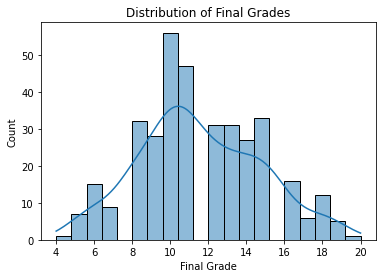

In [220]:
# Distribution de la variable cible
sns.histplot(df['FinalGrade'], bins=20, kde=True)
plt.xlabel('Final Grade')
plt.ylabel('Count')
plt.title('Distribution of Final Grades')
plt.show()

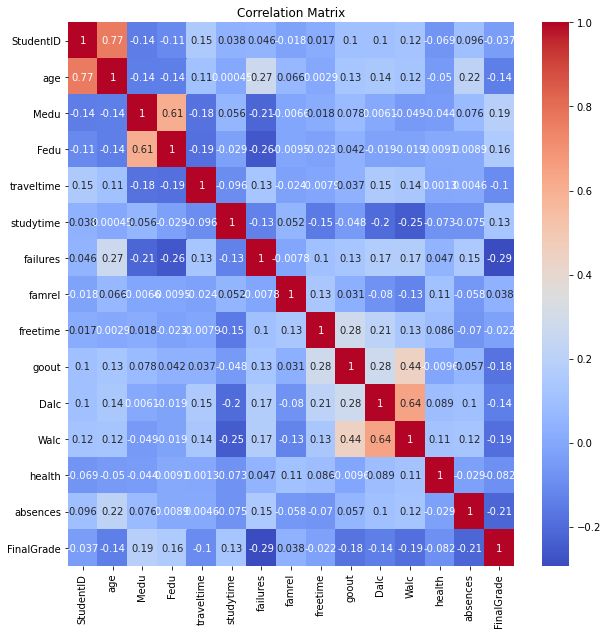

In [221]:
# Matrice de corrélation
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
# Heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

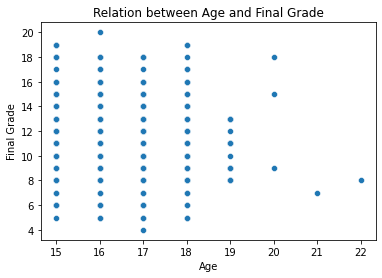

In [222]:
# Relation entre 'age' et 'FinalGrade'
sns.scatterplot(x='age', y='FinalGrade', data=df)
plt.xlabel('Age')
plt.ylabel('Final Grade')
plt.title('Relation between Age and Final Grade')
plt.show()

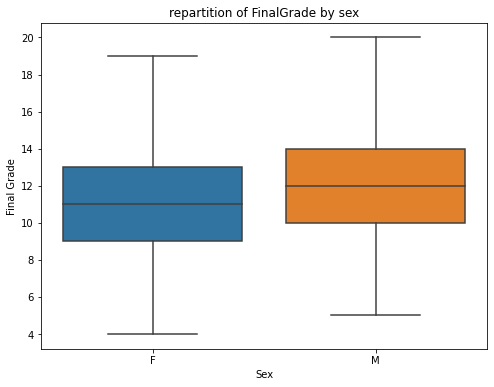

sex
F    11.205405
M    11.866279
Name: FinalGrade, dtype: float64


In [223]:
# Boxplot pour visualiser la répartition de l'âge par genre
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='FinalGrade', data=df)
plt.title('repartition of FinalGrade by sex')
plt.xlabel('Sex')
plt.ylabel('Final Grade')
plt.show()

# Calculer la moyenne de l'âge par genre
mean_age_by_genre = df.groupby('sex')['FinalGrade'].mean()
print(mean_age_by_genre)

In [224]:
# Sélectionner les colonnes numériques
df_num = df.select_dtypes(include=['int64', 'float64'])

# Sélectionner les colonnes de texte
df_cat = df.select_dtypes(include=['object'])

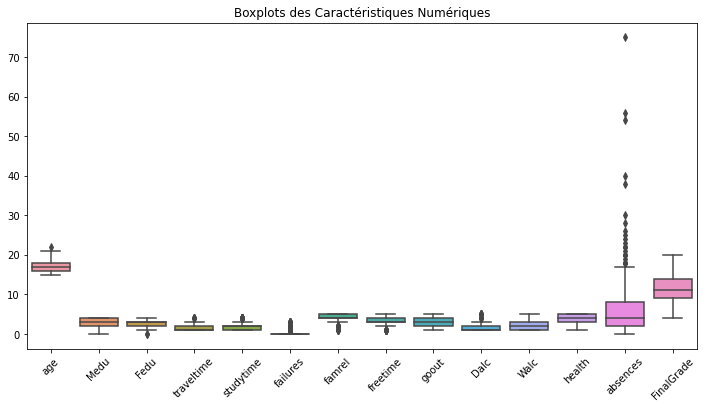

In [225]:
plt.figure(figsize=(12, 6))

# Utilisez Seaborn pour créer des boxplots pour toutes les caractéristiques numériques
sns.boxplot(data=df_num.drop(columns = 'StudentID'), orient='v')


plt.xticks(rotation=45)

plt.title('Boxplots des Caractéristiques Numériques')

plt.show()

### Création du score d'amélioration

In [226]:
# Sélectionnez les colonnes pertinentes pour le calcul du score
selected_columns = ['studytime', 'goout', 'Dalc', 'Walc', 'absences']

# Groupby par école et calculez les moyennes et les écart-types pour chaque colonne
school_stats = df.groupby('school')[selected_columns].agg(['mean', 'std'])

# Fonction pour standardiser une valeur en fonction de l'école et de la colonne
def standardize_value(row, column_name):
    school = row['school']
    value = row[column_name]
    mean = school_stats.loc[school, (column_name, 'mean')]
    std = school_stats.loc[school, (column_name, 'std')]
    if std == 0:
        # Évitez une division par zéro si l'écart-type est de zéro
        return 0
    else:
        return (value - mean) / std

# Créez une nouvelle colonne 'StandardizedScore' qui est la somme des colonnes standardisées
df['StandardizedScore'] = 0 
for column in selected_columns:
    if column != 'studytime':
        df['StandardizedScore'] += df.apply(standardize_value, axis=1, args=(column,))
    else:
        df['StandardizedScore'] -= df.apply(standardize_value, axis=1, args=(column,))
    

In [227]:
df.head()

,StudentID,FirstName,FamilyName,school,sex,age,address,famsize,Pstatus,Medu,...,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,FullName,StandardizedScore
0,0,Rafael,Morais,GP,F,18,U,GT3,A,4,...,4,3,4,1,1,3,6,6,Rafael Morais,-0.655039
1,1,Lara,Braga,GP,F,17,U,GT3,T,1,...,5,3,3,1,1,3,4,6,Lara Braga,-1.792440
2,2,Gonçalo,Azevedo,GP,F,15,U,LE3,T,1,...,4,3,2,2,3,3,10,10,Gonçalo Azevedo,0.659621
3,3,Lara,Perna,GP,F,15,U,GT3,T,4,...,3,2,2,1,1,5,2,15,Lara Perna,-4.112589
4,4,João,Pires,GP,F,16,U,GT3,T,3,...,4,3,2,1,2,5,4,10,João Pires,-1.934342


In [228]:
column_to_scale = 'StandardizedScore'

# Calculez les valeurs minimales et maximales de la colonne 'StandardizedScore' pour chaque école
min_max_by_school = df.groupby('school')[column_to_scale].agg(['min', 'max'])

# Fonction pour appliquer la mise à l'échelle Min-Max en fonction de l'école
def minmax_scale_by_school(row):
    school = row['school']
    value = row[column_to_scale]
    min_val = min_max_by_school.loc[school, 'min']
    max_val = min_max_by_school.loc[school, 'max']
    return (value - min_val) / (max_val - min_val)

# Appliquez la fonction de mise à l'échelle Min-Max à la colonne 'StandardizedScore'
df['ImprovableScore'] = df.apply(minmax_scale_by_school, axis=1)

# La colonne 'ImprovableScore' contiendra maintenant les valeurs de 'StandardizedScore' mises à l'échelle Min-Max en fonction de l'école

In [229]:
# Création d'une colonne indiquant les éléves à aider en priorité
df['Priority'] = df.apply(lambda row: 'Yes' if (row['FinalGrade'] < 10) and (row['ImprovableScore'] > 0.6) else 'No', axis=1)

In [230]:
df.drop(columns =['FirstName','FamilyName','StandardizedScore'],inplace=True)
ordered_columns = ['StudentID','FullName']
ordered_columns.extend(list(df.drop(columns =['StudentID','FullName']).columns))
df = df[ordered_columns]

In [231]:
df.head()

,StudentID,FullName,school,sex,age,address,famsize,Pstatus,Medu,Fedu,...,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,ImprovableScore,Priority
0,0,Rafael Morais,GP,F,18,U,GT3,A,4,4,...,4,3,4,1,1,3,6,6,0.310564,No
1,1,Lara Braga,GP,F,17,U,GT3,T,1,1,...,5,3,3,1,1,3,4,6,0.238099,No
2,2,Gonçalo Azevedo,GP,F,15,U,LE3,T,1,1,...,4,3,2,2,3,3,10,10,0.394321,No
3,3,Lara Perna,GP,F,15,U,GT3,T,4,2,...,3,2,2,1,1,5,2,15,0.090282,No
4,4,João Pires,GP,F,16,U,GT3,T,3,3,...,4,3,2,1,2,5,4,10,0.229059,No


In [232]:
df.to_csv('student_data_with_score.csv')

In [233]:
plt.figure(figsize=(10, 10))
fig = px.scatter(df, x="FinalGrade", y="ImprovableScore", hover_data='FullName',
                     title='Correlation between Improvable Score and Final Grade',
                     color='Priority', color_discrete_map={'Yes': 'red', 'No': 'blue'})
fig.update_xaxes(autorange="reversed")
fig.show()

<Figure size 720x720 with 0 Axes>

In [57]:
df.head()

,StudentID,FullName,school,sex,age,address,famsize,Pstatus,Medu,Fedu,...,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,ImprovableScore,Priority
0,0,Rafael Morais,GP,F,18,U,GT3,A,4,4,...,4,3,4,1,1,3,6,6,0.310564,No
1,1,Lara Braga,GP,F,17,U,GT3,T,1,1,...,5,3,3,1,1,3,4,6,0.238099,No
2,2,Gonçalo Azevedo,GP,F,15,U,LE3,T,1,1,...,4,3,2,2,3,3,10,10,0.394321,No
3,3,Lara Perna,GP,F,15,U,GT3,T,4,2,...,3,2,2,1,1,5,2,15,0.090282,No
4,4,João Pires,GP,F,16,U,GT3,T,3,3,...,4,3,2,1,2,5,4,10,0.229059,No


### Utilisation ML pour calculer un score

Initialement, j'avais l'intention de réaliser une régression en utilisant la variable "Finalgrade" comme variable cible. L'objectif était de prédire les notes finales des élèves en fonction de diverses caractéristiques. Ensuite, en analysant la pertinence de chaque caractéristique, je voulais créer un score qui mesurerait l'impact des variables actionnables sur la prédiction de la note finale. Cependant, les performances de mes modèles de régression étaient insuffisantes, ce qui signifie que les prédictions étaient de qualité médiocre et ne permettaient pas de créer un score fiable en fonction de ces variables actionnables.


In [108]:
#Je ne garde que les variables pertinentes pour la prédiction

df_reg = df.drop(columns = ['StudentID','FullName','ImprovableScore','Priority'])

In [60]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      357 non-null    object
 1   sex         357 non-null    object
 2   age         357 non-null    int64 
 3   address     357 non-null    object
 4   famsize     357 non-null    object
 5   Pstatus     357 non-null    object
 6   Medu        357 non-null    int64 
 7   Fedu        357 non-null    int64 
 8   Mjob        357 non-null    object
 9   Fjob        357 non-null    object
 10  reason      357 non-null    object
 11  guardian    357 non-null    object
 12  traveltime  357 non-null    int64 
 13  studytime   357 non-null    int64 
 14  failures    357 non-null    int64 
 15  schoolsup   357 non-null    object
 16  famsup      357 non-null    object
 17  paid        357 non-null    object
 18  activities  357 non-null    object
 19  nursery     357 non-null    object
 20  higher    

In [109]:
# Je supprime les outliers

df_reg = df_reg[df_reg['absences'] < 20]

In [62]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 356
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      338 non-null    object
 1   sex         338 non-null    object
 2   age         338 non-null    int64 
 3   address     338 non-null    object
 4   famsize     338 non-null    object
 5   Pstatus     338 non-null    object
 6   Medu        338 non-null    int64 
 7   Fedu        338 non-null    int64 
 8   Mjob        338 non-null    object
 9   Fjob        338 non-null    object
 10  reason      338 non-null    object
 11  guardian    338 non-null    object
 12  traveltime  338 non-null    int64 
 13  studytime   338 non-null    int64 
 14  failures    338 non-null    int64 
 15  schoolsup   338 non-null    object
 16  famsup      338 non-null    object
 17  paid        338 non-null    object
 18  activities  338 non-null    object
 19  nursery     338 non-null    object
 20  higher    

c:\Users\cleme\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='failures'>

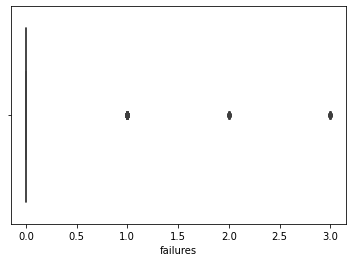

In [64]:
sns.boxplot(df_reg['failures'])

In [84]:
scaler = StandardScaler()
X = df_reg.drop(columns='FinalGrade')
y = df_reg['FinalGrade']

In [124]:
scale_columns = ['age','failures','absences']

In [125]:
X = pd.get_dummies(X,drop_first=True)

In [126]:
X.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,0,1,1,0,1,1,0,0


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [128]:
X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
rf = RandomForestRegressor()

In [131]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [132]:
rf.score(X_test,y_test)

0.15857245849563228

In [133]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Nombre d'arbres dans la forêt
    'max_features': [ 'sqrt', 'log2'],  # Nombre maximal de caractéristiques à considérer pour chaque division
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profondeur maximale de chaque arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],  # Nombre minimal d'échantillons requis pour être une feuille
    'bootstrap': [True, False]  # Utilisation de l'échantillonnage bootstrap pour construire les arbres
}

In [134]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train, y_train)


best_params = random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [135]:
random_search.best_score_

0.1792412456764724

In [136]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [137]:
xgb.score(X_test,y_test)

0.023885791396724088

In [138]:
param_grid = {
    'max_depth': np.arange(3, 10, 1),  # Profondeur maximale de chaque arbre
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Taux d'apprentissage
    'n_estimators': np.arange(100, 1000, 100),  # Nombre d'arbres dans la forêt
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction d'échantillons utilisée pour l'entraînement
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]  # Fraction de caractéristiques utilisée pour l'entraînement
}


In [139]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Entraînez la recherche aléatoire sur vos données d'entraînement
random_search.fit(X_train, y_train)

# Obtenez les meilleurs hyperparamètres trouvés
best_params = random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [140]:
best_params

{'subsample': 1.0,
 'n_estimators': 300,
 'max_depth': 8,
 'learning_rate': 0.01,
 'colsample_bytree': 0.6}

In [141]:
random_search.best_score_

0.17795840180747052

In [ ]:
rf= RandomForestRegressor(**random_search.best_params_)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mse

In [142]:
xgb = XGBRegressor(**random_search.best_params_)
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mse

8.760070797370426

In [143]:
elastic_net = ElasticNet()

# Je définis la grille des hyperparamètres à rechercher
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  # Terme de régularisation L1
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]  # Ratio entre la régularisation L1 et L2 (ElasticNet)
}


grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_

In [144]:
grid_search.best_score_

0.13208243049864904

In [146]:
elastic_net = ElasticNet(**grid_search.best_params_)
elastic_net.fit(X_train,y_train)

y_pred = elastic_net.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mse

8.531024484782002